In [9]:
#Data Manipulation
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.utils import shuffle
from tqdm import tqdm
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .80,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    }
}

In [3]:
def addNLags(df, lags_list):
    lag_df= df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Demanda_kWh"].shift(lag * 96).fillna(0)

    return lag_df.fillna(0)
def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.reset_index(inplace=True)
dates = df["Date"]
dates = pd.to_datetime(dates)

df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
df = addNLags(df, [1,2])
df = df.drop(columns=["Date"], axis=1)
df.columns = df.columns.map(str)

y = df["Demanda_kWh"]
X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
col_names = list(X.columns)

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_test, y_test = X.loc[trainingSize:, :].copy(), y.loc[trainingSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_test_dates = dates.loc[trainingSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12046
Training Size:9637
Test Size: 2410


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday', 'lag_1', 'lag_2'],
      dtype='object')

In [29]:
import plotly.graph_objects as go
def plotDatasetSplit(X_train_dates, X_test_dates, y_train, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (kWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.write_image("../results/dataset_split.png", width=1000, scale=2, format="png")
    fig.show()

In [30]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1300, learning_rate = 0.01, max_depth=9, colsample_bytree = .7, colsample_bynode = 0.7, gamma=7, random_state=123)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    verbose=0
)

y_pred = regressorXGBR.predict(X_test)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
rmse = root_mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
mape = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred))
mdape = median_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred))
print(f"MAE: {mae}, RMSE: {rmse}, MdAPE: {mdape}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=regressorXGBR.feature_names_in_, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 1.404217941190474, RMSE: 3.361373666626931, MdAPE: 10.856528772948224


,importance
temperature_2m_C,0.028532
isWeekend,0.043084
Month_cos,0.044419
diffuse_radiation_W/m2,0.051827
lag_2,0.055271
DayOfWeek_sin,0.055613
Hour_sin,0.056457
shortwave_radiation_W/m2,0.058311
isHoliday,0.058397
direct_normal_irradiance_W/m2,0.059500


In [31]:
df = pd.read_csv("../data/data_casal_montserratina/LaMonserratina_CLEAN.csv", index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
def split_train_test(data):
    train_list = []
    test_list = []

    # Agrupar por mes y año
    grouped = data.groupby([data.index.year, data.index.month])

    for _, group in grouped:
        # Ordenar por fecha dentro del grupo
        group = group.sort_index()
        # Tomar las tres primeras semanas como training
        train_list.append(group.iloc[:-8*24])
        # Tomar la última semana como test
        test_list.append(group.iloc[-8*24:])

    train = pd.concat(train_list)
    test = pd.concat(test_list)

    return train, test

# Divide el DataFrame
train, test = split_train_test(df)
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(train)}")
print(f"Test Size: {len(test)}")

Total Lags: 12046
Training Size:8782
Test Size: 3264


In [32]:
fig = go.Figure()
train2 = train.copy(deep=True)
test2 = test.copy(deep=True)
min_date = train2.index.min()
max_date = train2.index.max()


fig.add_trace(go.Scatter(x=train2.index, y=train2.Demanda_kWh, mode="lines", name="Train"))
fig.add_trace(go.Scatter(x=test2.index, y=test2.Demanda_kWh, mode="lines", name="Test"))
fig.update_layout(
    title = "Dataset Partition",
    xaxis_title = "Date",
    yaxis_title ="Demand (kWh)",
    width = 1000,
    height = 400,
    margin = dict(l=30, r=20, t=35, b=60),
    legend = dict(
        orientation = "h",
        yanchor = "bottom",
        y = 1.05,
        xanchor = "right",
        x=1
    )
)
fig.show()

In [33]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

train = train.drop(columns=["Date"], axis=1)
test_dates = test["Date"]
test = test.drop(columns=["Date"], axis=1)

df = addNLags(df, [1, 2])

train_y = train["Demanda_kWh"]
test_y = test["Demanda_kWh"]
train_x = train.drop(columns=["Demanda_kWh"], axis=1)
test_x = test.drop(columns=["Demanda_kWh"], axis=1)

regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1400, learning_rate = 0.003, max_depth=7, colsample_bytree = 0.9, colsample_bynode = 0.9, gamma=7, random_state=123)
regressorXGBR.fit(
    X = train_x,
    y = train_y
)
y_pred = regressorXGBR.predict(test_x)
print(f"XGBR MAE: {mean_absolute_error(test_y, y_pred)}, RMSE: {root_mean_squared_error(test_y, y_pred)}")

XGBR MAE: 2.747275979930422, RMSE: 6.233896160636889


In [34]:
test_dates

0      2022-07-24 00:00:00
1      2022-07-24 01:00:00
2      2022-07-24 02:00:00
3      2022-07-24 03:00:00
4      2022-07-24 04:00:00
               ...        
3259   2023-11-29 20:00:00
3260   2023-11-29 21:00:00
3261   2023-11-29 22:00:00
3262   2023-11-29 23:00:00
3263   2023-11-30 00:00:00
Name: Date, Length: 3264, dtype: datetime64[ns]

In [27]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()
    
plotPredictions(test_x.index, y_pred, test_y)

NameError: name 'test_x' is not defined

In [37]:
plotPredictions(test_x.index[:24*14], y_pred[:24*14], test_y[:24*14])

In [38]:
plotPredictions(test_x.index[:24*7], y_pred[:24*7], test_y[:24*7])

In [15]:
#Data Manipulation
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import plotly.graph_objects as go
import statsmodels as sm
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .80,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    }
}
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [16]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None, parse_dates=True, dayfirst=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df[["Demanda_kWh", "Date"]]
df.set_index("Date", inplace=True)
df = df.asfreq('H').fillna(0)
df["Consumo_log"] = df["Demanda_kWh"].apply(np.log1p)
df["Consumo_log_diff"] = df["Consumo_log"].diff()
split_index = int(0.8 * len(df))
train, test = df.iloc[:split_index], df.iloc[split_index:]

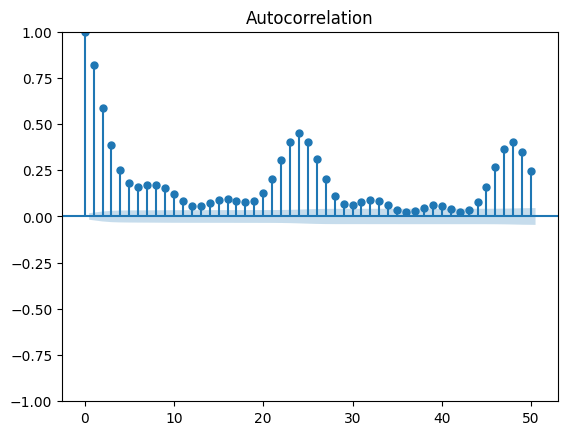

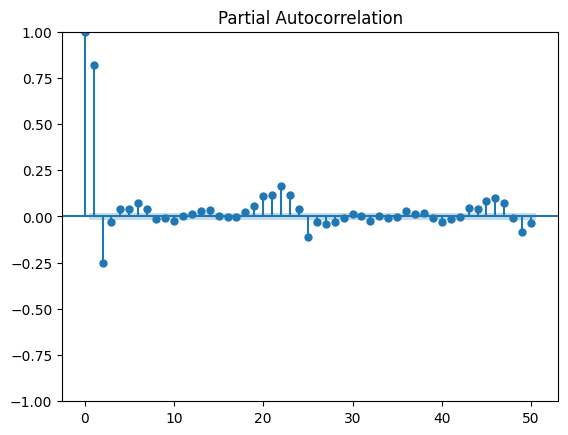

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df["Demanda_kWh"], lags=50)
pacf_original = plot_pacf(df["Demanda_kWh"], lags=50)

In [18]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = df["Demanda_kWh_log"],
    order = (2,0,2), # p => Lags d => Diff q => Moving  
    seasonal_order = (2,0,2,24),
    enforce_stationarity = False,
    enforce_invertibility = False
)
best_arima_model.initialize_approximate_diffuse() 
best_arima_model_fitted = best_arima_model.fit()
pred_uc = best_arima_model_fitted.get_forecast(steps = len(test))

AttributeError: module 'statsmodels.tsa' has no attribute 'statespace'

In [ ]:
pred_values = pred_uc.predicted_mean.values

mae = mean_absolute_error(test["Demanda_kWh_log"].values, pred_values)
rmse = root_mean_squared_error(test["Demanda_kWh_log"].values, pred_values)
print(f"MAE: {mae}, RMSE: {rmse}")
plotPredictions(test.index, pred_values, test["Demanda_kWh_log"].values)


MAE: 3.164275919266806, RMSE: 5.230054977484813
